This file is used to generate Fig S4

This is completely equivalent to Fig 2 in the main text, although now we assume that the costs and benefits of each active allele are normally distributed

In [11]:
from model import PModel

import numpy as np
from matplotlib import pyplot as plt

### Set global parameters used in all simulations

In [12]:
#Global parameters
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 1        #Baseline transmission rate

### The pareto_array function generates a series of randomly generated Pareto fronts, and calculates the average and standard deviation of costs for each value of resistance

In [13]:
#Compute the average Pareto front from a sequence of random genotype distributions
def pareto_array(n_loci, n_sims, n_steps=100, epi=0, beta=1):
	model = PModel(n_loci, np.zeros(n_loci), np.zeros(n_loci), beta=beta)

	coefs = np.zeros(n_sims)
	cost_grid = np.zeros((n_sims, n_steps))
	res_vals = np.linspace(0, 1, n_steps)

	for i in range(n_sims):
		cost = np.random.normal(0, 0.3, n_loci)
		res = np.random.normal(0, 0.3, n_loci)
		model.update_loci(res, cost)

		if epi == 1:
			model.add_epistasis(2, p1, sigma1)
		elif epi ==	2:
			model.add_epistasis(2, p1, sigma1)
			model.add_epistasis(3, p2, sigma2)

		model.normalize()

		res, fec = model.pareto()
		fec_interp = np.interp(res_vals, res, fec)

		coefs[i] = np.polyfit(1 - res, 1 - fec, 2)[0]
		cost_grid[i,:] = fec_interp

	cost_avg = np.average(cost_grid, axis=0)
	cost_std = np.std(cost_grid, axis=0)

	return cost_avg, cost_std, coefs

### This code runs three simulations of Pareto fronts for different levels of epistasis

In [14]:
#Initialize models for Figure
n_loci = 9

costs_epi0, err_epi0, coefs_0 = pareto_array(n_loci, 100, beta=beta)
costs_epi1, err_epi1, coefs_1 = pareto_array(n_loci, 100, epi=1)
costs_epi2, err_epi2, coefs_2 = pareto_array(n_loci, 100, epi=2)

model = PModel(n_loci, np.zeros(n_loci), np.zeros(n_loci), beta=beta)

/tmp/ipykernel_2299/2919112492.py:25: RankWarning: Polyfit may be poorly conditioned
  coefs[i] = np.polyfit(1 - res, 1 - fec, 2)[0]
/tmp/ipykernel_2299/2919112492.py:25: RankWarning: Polyfit may be poorly conditioned
  coefs[i] = np.polyfit(1 - res, 1 - fec, 2)[0]
/tmp/ipykernel_2299/2919112492.py:25: RankWarning: Polyfit may be poorly conditioned
  coefs[i] = np.polyfit(1 - res, 1 - fec, 2)[0]


In [15]:
print('Curvature values:')

print('means:', np.mean(coefs_0), np.mean(coefs_1), np.mean(coefs_2))
print('stdevs:', np.std(coefs_0), np.std(coefs_1), np.std(coefs_2))

Curvature values:
means: 3.451095836056955 1.6725836060880477 2.2036250268658115
stdevs: 9.031295750565372 10.48028880817974 5.023791430315527


In [16]:
def label_x_ticks(ax, vals, n_ticks = 4):
    x_lim = ax.get_xlim()
    x_ticks = np.linspace(x_lim[0], x_lim[1], n_ticks)
    x_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_xticks(x_ticks, x_tick_labels)

def label_y_ticks(ax, vals, n_ticks = 4):
    y_lim = ax.get_ylim()
    y_ticks = np.linspace(y_lim[0], y_lim[1], n_ticks)
    y_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_yticks(y_ticks, y_tick_labels)

### Code to generate the graphics for Figure S4

Text(-0.2, 1.1, 'F')

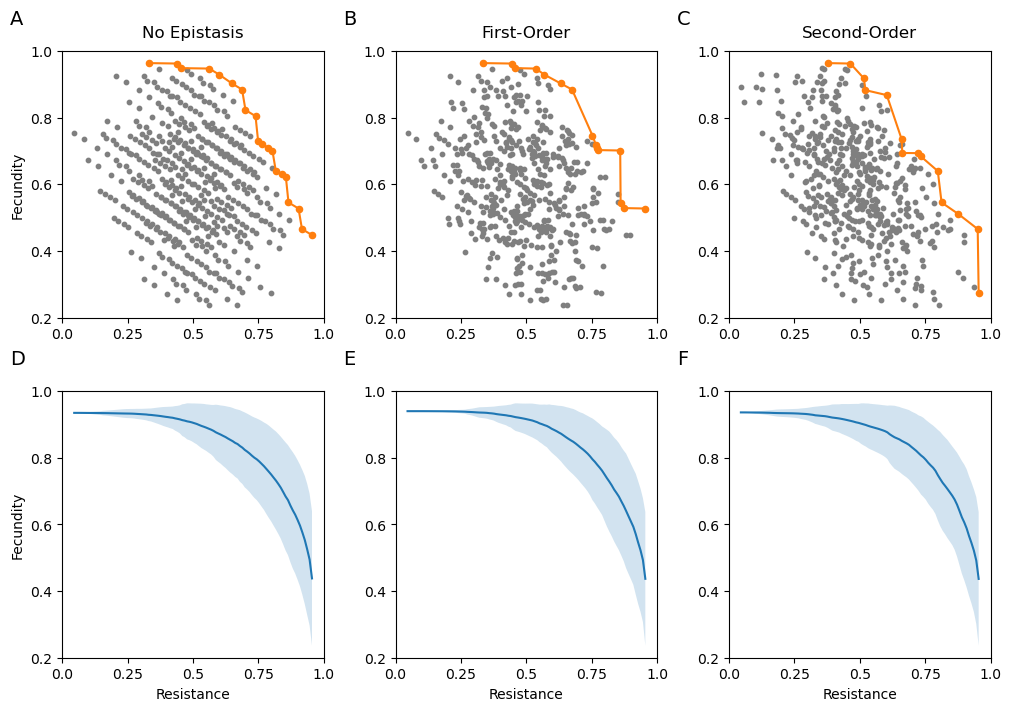

In [20]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 7), layout='constrained')

ax[0,0].set_title('No Epistasis', pad=10)
ax[0,1].set_title('First-Order', pad=10)
ax[0,2].set_title('Second-Order', pad=10)

cost = np.random.normal(0, 0.3, n_loci)
res = np.random.normal(0, 0.3, n_loci)
model.update_loci(res, cost)
model.normalize()
res_pareto, fec_pareto = model.pareto()

ax[0,0].scatter(1-model.B, model.F, c='tab:gray', s=10)
ax[0,0].scatter(1-res_pareto, fec_pareto, c='tab:orange', s=20)
ax[0,0].plot(1-res_pareto, fec_pareto, color='tab:orange')
ax[0,0].set_ylabel('Fecundity')

label_x_ticks(ax[0,0], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[0,0], (0.2, 0.4, 0.6, 0.8, 1), 5)

model.update_loci(res, cost)
model.add_epistasis(2, p1, sigma1)
model.normalize()
res_pareto, fec_pareto = model.pareto()

ax[0,1].scatter(1-model.B, model.F, c='tab:gray', s=10)
ax[0,1].scatter(1-res_pareto, fec_pareto, c='tab:orange', s=20)
ax[0,1].plot(1-res_pareto, fec_pareto, color='tab:orange')

label_x_ticks(ax[0,1], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[0,1], (0.2, 0.4, 0.6, 0.8, 1), 5)

model.update_loci(res, cost)
model.add_epistasis(2, p1, sigma1)
model.add_epistasis(3, p2, sigma2)
model.normalize()
res_pareto, fec_pareto = model.pareto()

ax[0,2].scatter(1-model.B, model.F, c='tab:gray', s=10)
ax[0,2].scatter(1-res_pareto, fec_pareto, c='tab:orange', s=20)
ax[0,2].plot(1-res_pareto, fec_pareto, color='tab:orange')

label_x_ticks(ax[0,2], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[0,2], (0.2, 0.4, 0.6, 0.8, 1), 5)

res_pts = np.linspace(0, 1, 100)

ax[1,0].plot(1-res_pts, costs_epi0)
ax[1,0].fill_between(1-res_pts, costs_epi0-err_epi0, costs_epi0+err_epi0, alpha=0.2)
ax[1,0].set_xlabel('Resistance')
ax[1,0].set_ylabel('Fecundity')

label_x_ticks(ax[1,0], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[1,0], (0.2, 0.4, 0.6, 0.8, 1), 5)

ax[1,1].plot(1-res_pts, costs_epi1)
ax[1,1].fill_between(1-res_pts, costs_epi1-err_epi1, costs_epi1+err_epi1, alpha=0.2)
ax[1,1].set_xlabel('Resistance')

label_x_ticks(ax[1,1], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[1,1], (0.2, 0.4, 0.6, 0.8, 1), 5)

ax[1,2].plot(1-res_pts, costs_epi2)
ax[1,2].fill_between(1-res_pts, costs_epi2-err_epi2, costs_epi2+err_epi2, alpha=0.2)
ax[1,2].set_xlabel('Resistance')

label_x_ticks(ax[1,2], (0, 0.25, 0.5, 0.75, 1), 5)
label_y_ticks(ax[1,2], (0.2, 0.4, 0.6, 0.8, 1), 5)

ax[0,0].annotate("A", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[0,1].annotate("B", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[0,2].annotate("C", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1,0].annotate("D", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1,1].annotate("E", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1,2].annotate("F", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)